# Final Project

In [1]:
"""
Import PyTorch libraries.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random

Ankle Boot


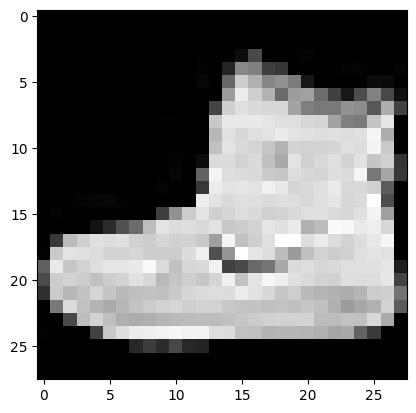

In [2]:
"""
Define the dataloader for the Fashion MNIST dataset.
"""
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
print(output_label(label))

In [3]:
class Sine(nn.Module):
    def __init__(self, omega_0=30):
        super().__init__()

        self.omega_0 = omega_0

    def forward(self, x):
        return torch.sin(self.omega_0 * x)

In [4]:
class SIREN(nn.Module):
    def __init__(self, input_dim=2, num_bands=3, hidden_dim=128, hidden_layers=2, output_dim=1, omega_0_initial=30, omega_0=1.0):
        super(SIREN, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.output_dim = output_dim
        self.omega_0_initial = omega_0_initial
        self.omega_0 = omega_0
        self.num_bands = num_bands

        encoded_dim = self.input_dim + 2 * self.input_dim * self.num_bands
        self.encoded_dim = encoded_dim

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(self.encoded_dim, self.hidden_dim))
        self.layers.append(Sine(self.omega_0_initial))

        for _ in range(hidden_layers):
            self.layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            self.layers.append(Sine(self.omega_0))

        self.layers.append(nn.Linear(self.hidden_dim, self.output_dim))
        self.sigmoid = nn.Sigmoid()
    
    def positional_encoding(self, coords):
        encoded = [coords]
        
        for i in range(self.num_bands):
            freq = 2.0 ** i
            encoded.append(torch.sin(coords * freq * np.pi))
            encoded.append(torch.cos(coords * freq * np.pi))
        
        return torch.cat(encoded, dim=-1)

    def forward(self, x):
        x = self.positional_encoding(x) 
        for layer in self.layers:
            x = layer(x)
        return self.sigmoid(x)

In [5]:
class VAE(nn.Module):
    def __init__(self, INN_hidden_dim=128, INN_num_bands=3, INN_hidden_layers=2):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(), 
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten()
        )

        self.mu = nn.Linear(4 * 4 * 128, 256)
        self.log_variance = nn.Linear(4 * 4 * 128, 256)

        self.INN_hidden_dim = INN_hidden_dim
        self.INN_hidden_layers = INN_hidden_layers
        self.INN_num_bands = INN_num_bands

        self.encoded_dim = 2 + 2 * 2 * self.INN_num_bands

        input_weights = self.encoded_dim * self.INN_hidden_dim + self.INN_hidden_dim
        hidden_weights = self.INN_hidden_layers * (self.INN_hidden_dim * self.INN_hidden_dim + self.INN_hidden_dim)
        output_weights = self.INN_hidden_dim * 1 + 1 

        self.total_weight = input_weights + hidden_weights + output_weights

        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),

            nn.Linear(2048, self.total_weight)
        )

    def reparameterize(self, mu, log_variance):
        sigma = torch.exp(0.5 * log_variance)
        epsilon = torch.randn_like(sigma)
        return mu + (sigma * epsilon)
    
    def forward(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        log_variance = self.log_variance(x)
        z = self.reparameterize(mu, log_variance)
        INN_weights = self.decoder(z)
        return INN_weights, mu, log_variance

In [ ]:
"""
Initialize Hyperparameters
"""
batch_size = 68
learning_rate = 0.0001
num_epochs = 1
image_size = 28

"""
Initialize the network and the Adam optimizer
"""
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae = VAE()
vae = vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)


"""
Generate INN weights
"""
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.'''
    if isinstance(sidelen, int):
        sidelen = dim * (sidelen,)

    if dim == 2:
        pixel_coords = np.stack(np.mgrid[:sidelen[0], :sidelen[1]], axis=-1)[None, ...].astype(np.float32)
        pixel_coords[0, :, :, 0] = pixel_coords[0, :, :, 0] / (sidelen[0] - 1)
        pixel_coords[0, :, :, 1] = pixel_coords[0, :, :, 1] / (sidelen[1] - 1)
    elif dim == 3:
        pixel_coords = np.stack(np.mgrid[:sidelen[0], :sidelen[1], :sidelen[2]], axis=-1)[None, ...].astype(np.float32)
        pixel_coords[..., 0] = pixel_coords[..., 0] / max(sidelen[0] - 1, 1)
        pixel_coords[..., 1] = pixel_coords[..., 1] / (sidelen[1] - 1)
        pixel_coords[..., 2] = pixel_coords[..., 2] / (sidelen[2] - 1)
    else:
        raise NotImplementedError('Not implemented for dim=%d' % dim)

    pixel_coords -= 0.5
    pixel_coords *= 2.
    pixel_coords = torch.Tensor(pixel_coords).view(-1, dim)
    return pixel_coords

"""
Function to create INN from weights generated by VAE decoder
"""
def create_inn_from_weights(weights, INN_hidden_dim=384, INN_hidden_layers=4, INN_num_bands=6, INN_output_dim=1, omega_0_initial=30, omega_0=1.0):    
    inn = SIREN(input_dim=2, num_bands=INN_num_bands, hidden_dim=INN_hidden_dim, 
                hidden_layers=INN_hidden_layers, output_dim=INN_output_dim, 
                omega_0_initial=omega_0_initial, omega_0=omega_0)
    
    # Add debugging for encoded_dim
    actual_input_dim = inn.layers[0].weight.shape[1]
    
    #  expected weight sizes
    input_params = actual_input_dim * INN_hidden_dim + INN_hidden_dim
    hidden_params = INN_hidden_layers * (INN_hidden_dim * INN_hidden_dim + INN_hidden_dim)
    output_params = INN_hidden_dim * INN_output_dim + INN_output_dim
    total_params = input_params + hidden_params + output_params
    
    encoded_dim = 2 + 2 * 2 * INN_num_bands
    
    start_idx = 0
    
    input_weights = weights[start_idx:start_idx + actual_input_dim * INN_hidden_dim].reshape(INN_hidden_dim, actual_input_dim)
    start_idx += actual_input_dim * INN_hidden_dim
    input_bias = weights[start_idx:start_idx + INN_hidden_dim]
    start_idx += INN_hidden_dim
    
    with torch.no_grad():
        inn.layers[0].weight.copy_(input_weights)
        inn.layers[0].bias.copy_(input_bias)
    
    for i in range(INN_hidden_layers):
        hidden_weights = weights[start_idx:start_idx + INN_hidden_dim * INN_hidden_dim].reshape(INN_hidden_dim, INN_hidden_dim)
        start_idx += INN_hidden_dim * INN_hidden_dim
        hidden_bias = weights[start_idx:start_idx + INN_hidden_dim]
        start_idx += INN_hidden_dim
        
        with torch.no_grad():
            inn.layers[2 + 2 * i].weight.copy_(hidden_weights)
            inn.layers[2 + 2 * i].bias.copy_(hidden_bias)
    
    output_weights = weights[start_idx:start_idx + INN_hidden_dim * INN_output_dim].reshape(INN_output_dim, INN_hidden_dim)
    start_idx += INN_hidden_dim * INN_output_dim
    output_bias = weights[start_idx:start_idx + INN_output_dim]
    
    with torch.no_grad():
        inn.layers[-1].weight.copy_(output_weights)
        inn.layers[-1].bias.copy_(output_bias)
    
    return inn

def create_inn_from_weights_batch(weights, INN_hidden_dim=384, INN_hidden_layers=4, INN_num_bands=6, INN_output_dim=1, omega_0_initial=30, omega_0=1.0):
    """
    Create a batch of SIREN networks from a batch of flattened weight vectors
    """
    batch_size = weights.shape[0]
    inns = []
    for i in range(batch_size):
        inn = create_inn_from_weights(
            weights[i], 
            INN_hidden_dim=INN_hidden_dim, 
            INN_hidden_layers=INN_hidden_layers,
            INN_num_bands=INN_num_bands,
            INN_output_dim=INN_output_dim, 
            omega_0_initial=omega_0_initial, 
            omega_0=omega_0
        )
        inns.append(inn)
    return inns

"""
Loss Function for VAE
"""
def loss_func(reconstructed_img, img, mu, log_variance, kl_weight=0.01):
    reconstruction_loss = F.binary_cross_entropy(reconstructed_img, img, reduction='sum')
    kl_divergence_loss = -0.5 * torch.sum(1 + log_variance - mu.pow(2) - log_variance.exp())
    return reconstruction_loss + kl_weight * kl_divergence_loss

"""
Training the VAE-INN network
"""
for epoch in range(num_epochs):
    vae.train()
    total_loss = 0
    
    for batch_idx, (img, _) in enumerate(train_loader):
        img = img.to(device)
        batch_size = img.shape[0]
        
        optimizer.zero_grad()
        
        inn_weights, mu, log_variance = vae(img)
        
        coords = get_mgrid(image_size).to(device)
    
        inns = create_inn_from_weights_batch(
            inn_weights,
            INN_hidden_dim=vae.INN_hidden_dim,
            INN_hidden_layers=vae.INN_hidden_layers,
            INN_num_bands=vae.INN_num_bands
        )
        
        reconstructed_batch = []
        for i, inn in enumerate(inns):
            inn = inn.to(device)
            with torch.no_grad():
                pixels = inn(coords) 
            
            reconstructed_image = pixels.reshape(image_size, image_size).unsqueeze(0)
            reconstructed_batch.append(reconstructed_image)
        
        reconstructed_batch = torch.cat(reconstructed_batch, dim=0)
        reconstructed_batch = reconstructed_batch.unsqueeze(1)
        
        loss = loss_func(reconstructed_batch, img, mu, log_variance) / batch_size
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 50 == 0:
            print('Epoch: [{}/{}], Train: [{}/{} ({:.0f}%)], Loss: {:.5f}'.format(
                        epoch + 1, num_epochs,
                        batch_idx * len(img), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader),
                        loss.item() / len(img)
                    ))

Epoch: [1/1], Train: [0/60000 (0%)], Loss: 11.63387
Epoch: [1/1], Train: [5000/60000 (8%)], Loss: 11.54694
Epoch: [1/1], Train: [10000/60000 (17%)], Loss: 11.59607
Epoch: [1/1], Train: [15000/60000 (25%)], Loss: 11.52189
Epoch: [1/1], Train: [20000/60000 (33%)], Loss: 11.52542
Epoch: [1/1], Train: [25000/60000 (42%)], Loss: 11.57788
Epoch: [1/1], Train: [30000/60000 (50%)], Loss: 11.56169
Epoch: [1/1], Train: [35000/60000 (58%)], Loss: 11.41266
Epoch: [1/1], Train: [40000/60000 (67%)], Loss: 11.58145
Epoch: [1/1], Train: [45000/60000 (75%)], Loss: 11.51840
Epoch: [1/1], Train: [50000/60000 (83%)], Loss: 11.57836
Epoch: [1/1], Train: [55000/60000 (92%)], Loss: 11.55489


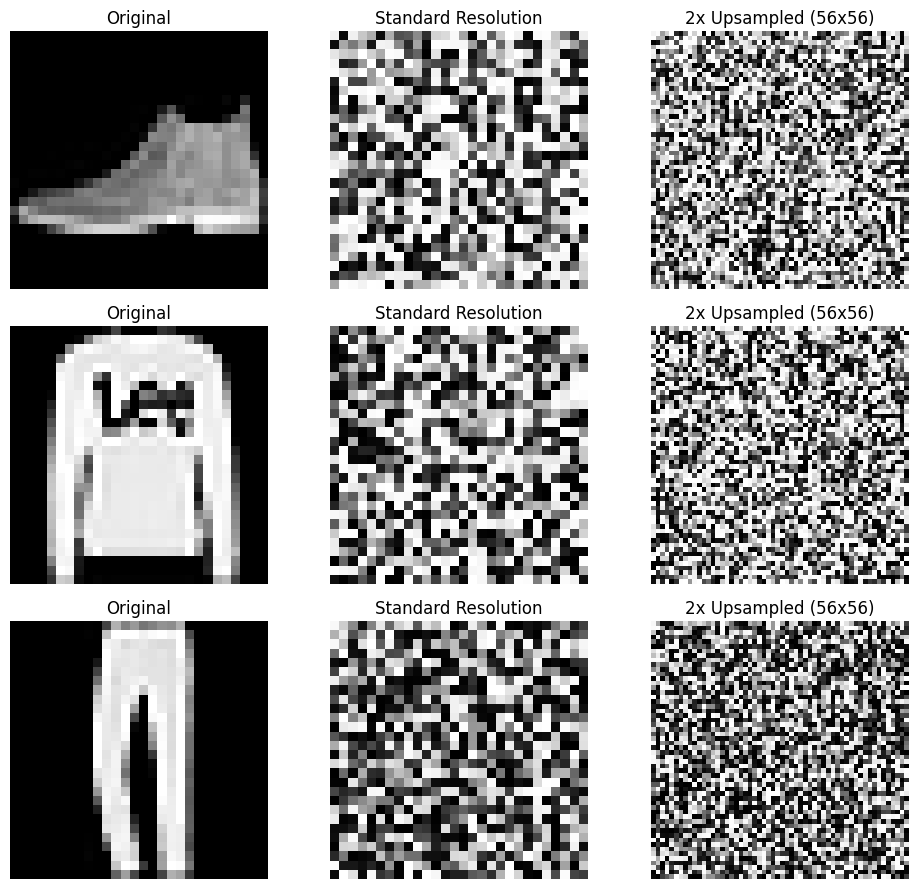

In [8]:
"""
The following part takes three images from test loader to feed into the VAE.
Shows original image and two different SIREN capabilities.
"""

import matplotlib.pyplot as plt
import numpy as np

vae.eval()
with torch.no_grad():
    imgs, _ = next(iter(test_loader))
    imgs = imgs[:3].to(device)  
    fig, ax = plt.subplots(3, 3, figsize=(10, 9))
    
    inn_weights, mu, log_variance = vae(imgs)
    
    for i in range(3):
        img = imgs[i].cpu().squeeze(0).numpy()
        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 0].set_title('Original')
        ax[i, 0].axis('off')

        inn = create_inn_from_weights(
            inn_weights[i], 
            INN_hidden_dim=vae.INN_hidden_dim, 
            INN_hidden_layers=vae.INN_hidden_layers,
            INN_num_bands=vae.INN_num_bands,
            INN_output_dim=1,
            omega_0_initial=30,
            omega_0=1.0
        ).to(device)
        
        standard_coords = get_mgrid(image_size).to(device)
        pixels = inn(standard_coords)
        standard_image = pixels.reshape(image_size, image_size)
        std_img = standard_image.cpu().numpy()
        
        ax[i, 1].imshow(std_img, cmap='gray')
        ax[i, 1].set_title('Standard Resolution')
        ax[i, 1].axis('off')
        
        upsampled_size = image_size * 2
        upsampled_coords = get_mgrid(upsampled_size).to(device)
        upsampled_pixels = inn(upsampled_coords)
        upsampled_image = upsampled_pixels.reshape(upsampled_size, upsampled_size)
        up_img = upsampled_image.cpu().numpy()
        
        ax[i, 2].imshow(up_img, cmap='gray')
        ax[i, 2].set_title(f'2x Upsampled ({upsampled_size}x{upsampled_size})')
        ax[i, 2].axis('off')
    
    plt.tight_layout()
    plt.savefig('siren_capabilities.png')
    plt.show()

Using device: cpu


Epoch 1/1:   0%|          | 4/3750 [00:00<03:23, 18.41it/s]

Batch 0/3750: Loss: 0.192342, Recon: 0.192342, KL: 0.000039, Beta: 0.000000


Epoch 1/1:   3%|▎         | 106/3750 [00:04<02:22, 25.54it/s]

Batch 100/3750: Loss: 0.186560, Recon: 0.186560, KL: 0.000039, Beta: 0.000000


Epoch 1/1:   5%|▌         | 205/3750 [00:08<02:15, 26.13it/s]

Batch 200/3750: Loss: 0.207305, Recon: 0.207305, KL: 0.000039, Beta: 0.000000


Epoch 1/1:   8%|▊         | 304/3750 [00:12<02:13, 25.77it/s]

Batch 300/3750: Loss: 0.211130, Recon: 0.211130, KL: 0.000039, Beta: 0.000000


Epoch 1/1:  11%|█         | 406/3750 [00:16<02:09, 25.92it/s]

Batch 400/3750: Loss: 0.189870, Recon: 0.189870, KL: 0.000039, Beta: 0.000000


Epoch 1/1:  13%|█▎        | 503/3750 [00:20<02:24, 22.51it/s]

Batch 500/3750: Loss: 0.187532, Recon: 0.187532, KL: 0.000040, Beta: 0.000000


Epoch 1/1:  16%|█▌        | 604/3750 [00:25<02:28, 21.17it/s]

Batch 600/3750: Loss: 0.188381, Recon: 0.188381, KL: 0.000041, Beta: 0.000000


Epoch 1/1:  19%|█▊        | 703/3750 [00:29<02:05, 24.34it/s]

Batch 700/3750: Loss: 0.193826, Recon: 0.193826, KL: 0.000038, Beta: 0.000000


Epoch 1/1:  21%|██▏       | 805/3750 [00:33<01:57, 25.10it/s]

Batch 800/3750: Loss: 0.185275, Recon: 0.185275, KL: 0.000040, Beta: 0.000000


Epoch 1/1:  24%|██▍       | 904/3750 [00:37<01:52, 25.41it/s]

Batch 900/3750: Loss: 0.198289, Recon: 0.198289, KL: 0.000041, Beta: 0.000000


Epoch 1/1:  27%|██▋       | 1006/3750 [00:41<01:48, 25.23it/s]

Batch 1000/3750: Loss: 0.198607, Recon: 0.198607, KL: 0.000040, Beta: 0.000000


Epoch 1/1:  29%|██▉       | 1105/3750 [00:45<01:44, 25.41it/s]

Batch 1100/3750: Loss: 0.204806, Recon: 0.204806, KL: 0.000039, Beta: 0.000000


Epoch 1/1:  32%|███▏      | 1204/3750 [00:49<01:46, 23.91it/s]

Batch 1200/3750: Loss: 0.195962, Recon: 0.195962, KL: 0.000040, Beta: 0.000000


Epoch 1/1:  35%|███▍      | 1306/3750 [00:53<01:35, 25.46it/s]

Batch 1300/3750: Loss: 0.199057, Recon: 0.199057, KL: 0.000040, Beta: 0.000000


Epoch 1/1:  37%|███▋      | 1405/3750 [00:57<01:34, 24.91it/s]

Batch 1400/3750: Loss: 0.206595, Recon: 0.206595, KL: 0.000039, Beta: 0.000000


Epoch 1/1:  40%|████      | 1504/3750 [01:01<01:51, 20.15it/s]

Batch 1500/3750: Loss: 0.191656, Recon: 0.191656, KL: 0.000039, Beta: 0.000000


Epoch 1/1:  43%|████▎     | 1604/3750 [01:06<01:38, 21.69it/s]

Batch 1600/3750: Loss: 0.183558, Recon: 0.183558, KL: 0.000039, Beta: 0.000000


Epoch 1/1:  45%|████▌     | 1706/3750 [01:10<01:18, 25.91it/s]

Batch 1700/3750: Loss: 0.197997, Recon: 0.197997, KL: 0.000039, Beta: 0.000000


Epoch 1/1:  48%|████▊     | 1803/3750 [01:15<01:40, 19.36it/s]

Batch 1800/3750: Loss: 0.201063, Recon: 0.201063, KL: 0.000040, Beta: 0.000000


Epoch 1/1:  51%|█████     | 1903/3750 [01:19<01:26, 21.30it/s]

Batch 1900/3750: Loss: 0.209229, Recon: 0.209229, KL: 0.000040, Beta: 0.000000


Epoch 1/1:  53%|█████▎    | 2004/3750 [01:24<01:22, 21.21it/s]

Batch 2000/3750: Loss: 0.211183, Recon: 0.211183, KL: 0.000040, Beta: 0.000000


Epoch 1/1:  56%|█████▌    | 2106/3750 [01:28<01:02, 26.12it/s]

Batch 2100/3750: Loss: 0.207180, Recon: 0.207180, KL: 0.000040, Beta: 0.000000


Epoch 1/1:  59%|█████▉    | 2205/3750 [01:32<00:59, 25.79it/s]

Batch 2200/3750: Loss: 0.200790, Recon: 0.200790, KL: 0.000040, Beta: 0.000000


Epoch 1/1:  61%|██████▏   | 2303/3750 [01:36<01:08, 21.04it/s]

Batch 2300/3750: Loss: 0.196120, Recon: 0.196120, KL: 0.000040, Beta: 0.000000


Epoch 1/1:  64%|██████▍   | 2405/3750 [01:40<00:52, 25.51it/s]

Batch 2400/3750: Loss: 0.198100, Recon: 0.198100, KL: 0.000039, Beta: 0.000000


Epoch 1/1:  67%|██████▋   | 2504/3750 [01:44<00:48, 25.96it/s]

Batch 2500/3750: Loss: 0.203130, Recon: 0.203130, KL: 0.000040, Beta: 0.000000


Epoch 1/1:  69%|██████▉   | 2606/3750 [01:48<00:44, 25.66it/s]

Batch 2600/3750: Loss: 0.199813, Recon: 0.199813, KL: 0.000040, Beta: 0.000000


Epoch 1/1:  72%|███████▏  | 2705/3750 [01:52<00:40, 25.74it/s]

Batch 2700/3750: Loss: 0.204457, Recon: 0.204457, KL: 0.000039, Beta: 0.000000


Epoch 1/1:  75%|███████▍  | 2804/3750 [01:56<00:36, 25.88it/s]

Batch 2800/3750: Loss: 0.195699, Recon: 0.195699, KL: 0.000040, Beta: 0.000000


Epoch 1/1:  77%|███████▋  | 2906/3750 [02:00<00:33, 25.41it/s]

Batch 2900/3750: Loss: 0.198055, Recon: 0.198055, KL: 0.000040, Beta: 0.000000


Epoch 1/1:  80%|████████  | 3005/3750 [02:04<00:30, 24.28it/s]

Batch 3000/3750: Loss: 0.185486, Recon: 0.185486, KL: 0.000039, Beta: 0.000000


Epoch 1/1:  83%|████████▎ | 3104/3750 [02:07<00:25, 25.59it/s]

Batch 3100/3750: Loss: 0.191689, Recon: 0.191689, KL: 0.000041, Beta: 0.000000


Epoch 1/1:  85%|████████▌ | 3206/3750 [02:12<00:22, 24.49it/s]

Batch 3200/3750: Loss: 0.202564, Recon: 0.202564, KL: 0.000039, Beta: 0.000000


Epoch 1/1:  88%|████████▊ | 3306/3750 [02:17<00:18, 23.51it/s]

Batch 3300/3750: Loss: 0.193019, Recon: 0.193019, KL: 0.000040, Beta: 0.000000


Epoch 1/1:  91%|█████████ | 3404/3750 [02:22<00:16, 20.49it/s]

Batch 3400/3750: Loss: 0.205351, Recon: 0.205351, KL: 0.000040, Beta: 0.000000


Epoch 1/1:  93%|█████████▎| 3506/3750 [02:26<00:09, 25.30it/s]

Batch 3500/3750: Loss: 0.200371, Recon: 0.200371, KL: 0.000038, Beta: 0.000000


Epoch 1/1:  96%|█████████▌| 3605/3750 [02:31<00:05, 24.95it/s]

Batch 3600/3750: Loss: 0.206159, Recon: 0.206159, KL: 0.000039, Beta: 0.000000


Epoch 1/1:  99%|█████████▉| 3704/3750 [02:35<00:01, 25.27it/s]

Batch 3700/3750: Loss: 0.198925, Recon: 0.198925, KL: 0.000038, Beta: 0.000000


Epoch 1/1: 100%|██████████| 3750/3750 [02:37<00:00, 23.74it/s]


Epoch [1/1] Loss: 0.198420, Recon: 0.198420, KL: 0.000040, LR: 0.000500
Training complete!


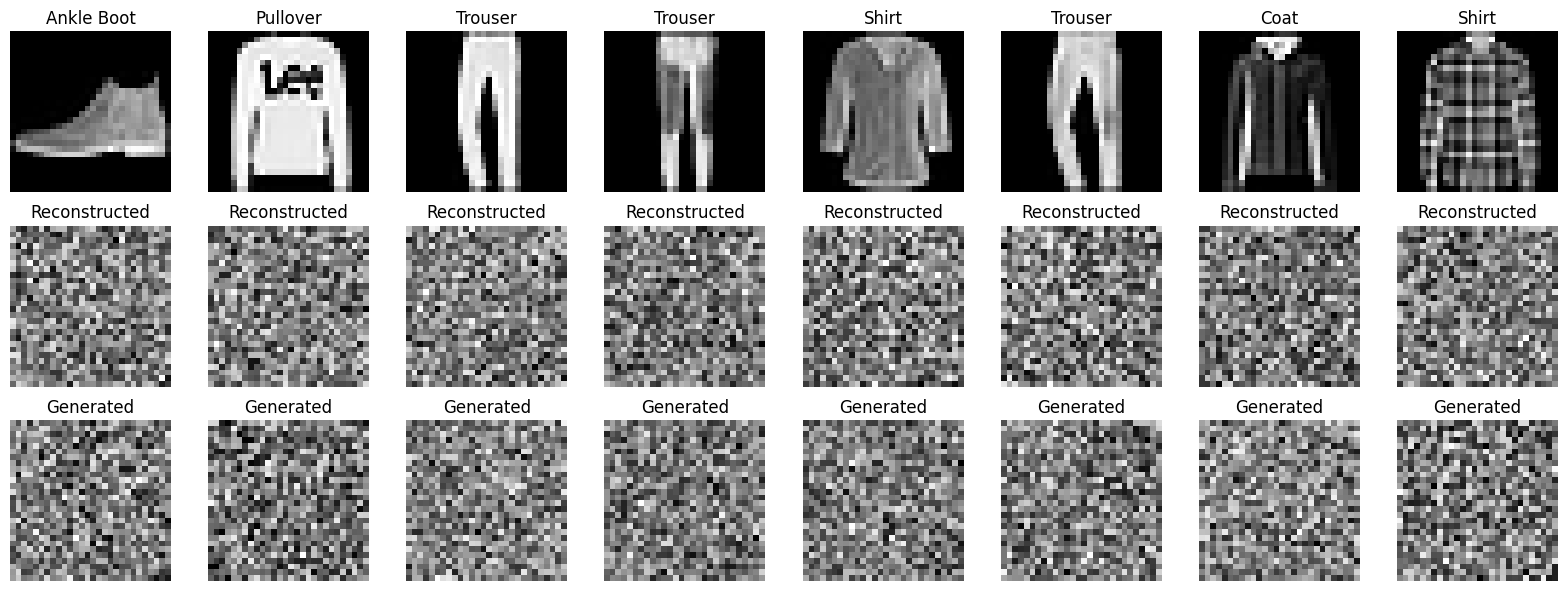

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=transform)

batch_size = 16  
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

def positional_encoding(coords, num_bands=8):
    """Apply positional encoding to coordinates with multiple frequency bands."""
    pos_enc = [coords]
    for i in range(num_bands):
        freq = 2.0 ** i
        pos_enc.append(torch.sin(coords * freq * np.pi))
        pos_enc.append(torch.cos(coords * freq * np.pi))
    return torch.cat(pos_enc, dim=-1)

def get_mgrid(sidelen, dim=2, num_bands=8):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.'''
    if isinstance(sidelen, int):
        sidelen = dim * (sidelen,)
    coords = [torch.linspace(-1, 1, s) for s in sidelen]
    mesh_coords = torch.meshgrid(*coords, indexing='ij')  
    coords = torch.stack(mesh_coords, dim=-1).reshape(-1, dim)
    return positional_encoding(coords, num_bands)

class SIREN(nn.Module):
    def __init__(self, input_dim=2+2*2*8, hidden_dim=256, hidden_layers=3, output_dim=1, first_omega=30.0, hidden_omega=30.0):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.output_dim = output_dim
        self.first_omega = first_omega
        self.hidden_omega = hidden_omega

        self.first_layer = nn.Linear(input_dim, hidden_dim)
        with torch.no_grad():

            self.first_layer.weight.uniform_(-1/input_dim, 1/input_dim)
            self.first_layer.bias.uniform_(-1/input_dim, 1/input_dim)
        
        self.hidden_layers_list = nn.ModuleList()
        for _ in range(hidden_layers):
            layer = nn.Linear(hidden_dim, hidden_dim)
            with torch.no_grad():

                layer.weight.uniform_(-np.sqrt(6/hidden_dim)/hidden_omega, 
                                      np.sqrt(6/hidden_dim)/hidden_omega)
                layer.bias.uniform_(-np.sqrt(6/hidden_dim)/hidden_omega, 
                                    np.sqrt(6/hidden_dim)/hidden_omega)
            self.hidden_layers_list.append(layer)
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        with torch.no_grad():

            self.output_layer.weight.uniform_(-np.sqrt(6/hidden_dim)/hidden_omega, 
                                              np.sqrt(6/hidden_dim)/hidden_omega)
            self.output_layer.bias.uniform_(-1, 1)
    
    def forward(self, x):
        x = torch.sin(self.first_omega * self.first_layer(x))
        for layer in self.hidden_layers_list:
            x = torch.sin(self.hidden_omega * layer(x))

        return torch.sigmoid(self.output_layer(x))
    
    def set_weights_vector(self, weights_vector):
        """Set all weights from a flattened vector"""
        start_idx = 0
        

        w_size = self.first_layer.weight.numel()
        self.first_layer.weight.data = weights_vector[start_idx:start_idx+w_size].view(self.first_layer.weight.shape)
        start_idx += w_size
        
        b_size = self.first_layer.bias.numel()
        self.first_layer.bias.data = weights_vector[start_idx:start_idx+b_size].view(self.first_layer.bias.shape)
        start_idx += b_size
        

        for layer in self.hidden_layers_list:
            w_size = layer.weight.numel()
            layer.weight.data = weights_vector[start_idx:start_idx+w_size].view(layer.weight.shape)
            start_idx += w_size
            
            b_size = layer.bias.numel()
            layer.bias.data = weights_vector[start_idx:start_idx+b_size].view(layer.bias.shape)
            start_idx += b_size
        

        w_size = self.output_layer.weight.numel()
        self.output_layer.weight.data = weights_vector[start_idx:start_idx+w_size].view(self.output_layer.weight.shape)
        start_idx += w_size
        
        b_size = self.output_layer.bias.numel()
        self.output_layer.bias.data = weights_vector[start_idx:start_idx+b_size].view(self.output_layer.bias.shape)
    
    @staticmethod
    def calc_total_weights(input_dim, hidden_dim, hidden_layers, output_dim):
        """Calculate the total number of weights in the SIREN"""
        total = input_dim * hidden_dim + hidden_dim
        
        total += hidden_layers * (hidden_dim * hidden_dim + hidden_dim)
        
        total += hidden_dim * output_dim + output_dim
        
        return total

class VAE(nn.Module):
    def __init__(self, z_dim=64, siren_config=None):
        super().__init__()
        self.z_dim = z_dim
        
        # Default SIREN config
        self.siren_config = {
            'input_dim': 2 + 2*2*8,  
            'hidden_dim': 128,       
            'hidden_layers': 3,       
            'output_dim': 1
        }
        
        # Update config if provided
        if siren_config is not None:
            self.siren_config.update(siren_config)
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),             # 28x28 -> 14x14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),            # 14x14 -> 7x7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),           # 7x7 -> 7x7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        

        self.fc_mu = nn.Linear(512, z_dim)
        self.fc_logvar = nn.Linear(512, z_dim)
        

        total_weights = SIREN.calc_total_weights(
            input_dim=self.siren_config['input_dim'],
            hidden_dim=self.siren_config['hidden_dim'],
            hidden_layers=self.siren_config['hidden_layers'],
            output_dim=self.siren_config['output_dim']
        )
        

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, total_weights) 
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, -4, 4)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


def train(num_epochs=10, save_interval=1):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    

    num_bands = 8
    siren_config = {
        'input_dim': 2 + 2*2*num_bands,
        'hidden_dim': 128, 
        'hidden_layers': 3, 
        'output_dim': 1,
    }
    

    vae = VAE(z_dim=64, siren_config=siren_config).to(device) 
    siren = SIREN(
        input_dim=siren_config['input_dim'],
        hidden_dim=siren_config['hidden_dim'],
        hidden_layers=siren_config['hidden_layers'],
        output_dim=siren_config['output_dim']
    ).to(device)
    
    optimizer = torch.optim.Adam(vae.parameters(), lr=0.0005, betas=(0.9, 0.999))
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    coords = get_mgrid(28, num_bands=num_bands).to(device)
    
    example_data = next(iter(test_loader))
    example_images = example_data[0][:8].to(device)
    
    best_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        vae.train()
        total_loss = 0
        total_recon_loss = 0
        total_kl_loss = 0
        
        for batch_idx, (images, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            images = images.to(device)
            batch_size = images.size(0)
            
            optimizer.zero_grad()
            
            siren_weights_batch, mu, logvar = vae(images)
            
            reconstruction_loss = 0
            
            reconstructed_images = []
            for j in range(batch_size):
                siren.set_weights_vector(siren_weights_batch[j])
                
                reconstructed_image = siren(coords).reshape(1, 1, 28, 28)
                reconstructed_images.append(reconstructed_image)
            
            reconstructed_batch = torch.cat(reconstructed_images, dim=0)
            
            reconstruction_loss = F.mse_loss(reconstructed_batch, images)
            
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            kl_loss = kl_loss / (batch_size * 28 * 28)  
            
            beta = 0.0005 * min(1.0, epoch / 5)  
            loss = reconstruction_loss + beta * kl_loss
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            

            optimizer.step()
            
            total_loss += loss.item()
            total_recon_loss += reconstruction_loss.item()
            total_kl_loss += kl_loss.item()
            

            if batch_idx % 100 == 0:
                print(f"Batch {batch_idx}/{len(train_loader)}: "
                      f"Loss: {loss.item():.6f}, "
                      f"Recon: {reconstruction_loss.item():.6f}, "
                      f"KL: {kl_loss.item():.6f}, "
                      f"Beta: {beta:.6f}")
        

        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        

        avg_loss = total_loss / len(train_loader)
        avg_recon = total_recon_loss / len(train_loader)
        avg_kl = total_kl_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Loss: {avg_loss:.6f}, "
              f"Recon: {avg_recon:.6f}, "
              f"KL: {avg_kl:.6f}, "
              f"LR: {current_lr:.6f}")
        

        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0

            torch.save({
                'vae_state_dict': vae.state_dict(),
                'siren_config': siren_config,
                'epoch': epoch,
                'loss': avg_loss
            }, 'best_vae_siren_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        if epoch % save_interval == 0:
            with torch.no_grad():
                vae.eval()
                

                test_recon_images = []
                for i in range(example_images.size(0)):
                    # Encode and decode
                    mu, logvar = vae.encode(example_images[i:i+1])
                    z = vae.reparameterize(mu, logvar)
                    siren_weights = vae.decode(z)
                    
                    # Set weights and get reconstruction
                    siren.set_weights_vector(siren_weights.squeeze(0))
                    recon_image = siren(coords).reshape(1, 28, 28)
                    test_recon_images.append(recon_image)
                
                # Stack the images
                test_recon_images = torch.cat(test_recon_images, dim=0)
                
                # Generate random samples
                z = torch.randn(8, vae.z_dim, device=device)
                generated_images = []
                for i in range(z.size(0)):
                    siren_weights = vae.decode(z[i:i+1])
                    siren.set_weights_vector(siren_weights.squeeze(0))
                    gen_image = siren(coords).reshape(1, 28, 28)
                    generated_images.append(gen_image)
                

                generated_images = torch.cat(generated_images, dim=0)
                

                plt.figure(figsize=(12, 8))
                

                for i in range(8):
                    plt.subplot(3, 8, i + 1)
                    plt.imshow(example_images[i].cpu().squeeze(), cmap='gray')
                    plt.axis('off')
                    plt.title("Original")
                
                for i in range(8):
                    plt.subplot(3, 8, i + 9)
                    plt.imshow(test_recon_images[i].cpu().squeeze(), cmap='gray')
                    plt.axis('off')
                    plt.title("Reconstructed")
                
                # Plot generated images
                for i in range(8):
                    plt.subplot(3, 8, i + 17)
                    plt.imshow(generated_images[i].cpu().squeeze(), cmap='gray')
                    plt.axis('off')
                    plt.title("Generated")
                
                plt.suptitle(f"Epoch {epoch+1}")
                plt.tight_layout()
                plt.savefig(f"vae_siren_epoch_{epoch+1}.png")
                plt.close()
    
    print("Training complete!")
    return vae, siren

def evaluate_model(model_path='best_vae_siren_model.pt'):
    # Load model
    checkpoint = torch.load(model_path)
    siren_config = checkpoint['siren_config']
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    vae = VAE(z_dim=64, siren_config=siren_config).to(device)
    vae.load_state_dict(checkpoint['vae_state_dict'])
    
    siren = SIREN(
        input_dim=siren_config['input_dim'],
        hidden_dim=siren_config['hidden_dim'],
        hidden_layers=siren_config['hidden_layers'],
        output_dim=siren_config['output_dim']
    ).to(device)
    
    coords = get_mgrid(28, num_bands=8).to(device)
    
    example_data = next(iter(test_loader))
    test_images = example_data[0][:8].to(device)
    test_labels = example_data[1][:8]
    
    vae.eval()
    with torch.no_grad():
        reconstructed_images = []
        for i in range(test_images.size(0)):
            mu, logvar = vae.encode(test_images[i:i+1])
            z = vae.reparameterize(mu, logvar)
            siren_weights = vae.decode(z)
            
            siren.set_weights_vector(siren_weights.squeeze(0))
            recon_image = siren(coords).reshape(1, 28, 28)
            reconstructed_images.append(recon_image)
        
        reconstructed_images = torch.cat(reconstructed_images, dim=0)
        
        z = torch.randn(8, vae.z_dim, device=device)
        generated_images = []
        for i in range(z.size(0)):
            siren_weights = vae.decode(z[i:i+1])
            siren.set_weights_vector(siren_weights.squeeze(0))
            gen_image = siren(coords).reshape(1, 28, 28)
            generated_images.append(gen_image)
        
        generated_images = torch.cat(generated_images, dim=0)
    
    fig, axs = plt.subplots(3, 8, figsize=(16, 6))
    
    for i in range(8):
        # Original
        axs[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
        axs[0, i].set_title(f"{class_names[test_labels[i]]}")
        axs[0, i].axis('off')
        
        # Reconstructed
        axs[1, i].imshow(reconstructed_images[i].cpu().squeeze(), cmap='gray')
        axs[1, i].set_title("Reconstructed")
        axs[1, i].axis('off')
        
        # Generated
        axs[2, i].imshow(generated_images[i].cpu().squeeze(), cmap='gray')
        axs[2, i].set_title("Generated")
        axs[2, i].axis('off')
    
    plt.tight_layout()
    plt.savefig("evaluation_results.png")
    plt.show()
    
    return vae, siren

if __name__ == "__main__":
    vae, siren = train(num_epochs=1, save_interval=1)
    evaluate_model()